In [1]:
from fabrictestbed_extensions.fablib.fablib import FablibManager as fablib_manager
fablib = fablib_manager()


In [2]:
import numpy as np
import pandas as pd

In [3]:
slice_name = 'Experiment 1.3'

site1 = 'GPN'  
site2 = 'SALT'

node1_name = 'Node1'
node2_name = 'Node2'
node3_name = 'Node3'
network1_2_name='net1_2'
network2_3_name='net2_3'
node1_nic_name = 'nic1'
node2_1_nic_name = 'nic2_1'
node2_3_nic_name = 'nic2_3'
node3_nic_name = 'nic3'
image='default_ubuntu_20'

cores = 2
ram = 8
disk = 10

In [4]:
slice = fablib.get_slice(name=slice_name)
node1 = slice.get_node(name=node1_name)
node2 = slice.get_node(name=node2_name) 
node3 = slice.get_node(name=node3_name)
node1_addr = "192.168.1.1"
node2_1_addr = "192.168.1.2"
node2_3_addr = "192.168.2.1"
node3_addr = "192.168.2.2"

In [5]:
node1.execute("ls")

('', '')

In [6]:
try:
    for node in slice.get_nodes():
        print(f"{node}")
except Exception as e:
    print(f"Exception: {e}")

-----------------  ------------------------------------------------------------------------------------------------------------------------------------------------
ID                 422c4897-5688-48a6-b94a-296b9e6f4025
Name               Node1
Cores              2
RAM                8
Disk               10
Image              default_ubuntu_20
Image Type         qcow2
Host               gpn-w4.fabric-testbed.net
Site               GPN
Management IP      2610:e0:a04c:fab2:f816:3eff:fe2e:d153
Reservation State  Active
Error Message
SSH Command        ssh -i /home/fabric/work/fabric_config/.ssh/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2610:e0:a04c:fab2:f816:3eff:fe2e:d153
-----------------  ------------------------------------------------------------------------------------------------------------------------------------------------
-----------------  ---------------------------------------------------------------------------------------------------------------------

### Get Latency from ping

In [7]:
def ping_to_df(node,ip,packet_size=""):
    try:
        pings = 5

        # extract times
        ping_n_times = 5
        times = []
        for i in range(ping_n_times):
            stdout, stderr = node.execute(f'ping -c {pings} {packet_size} {ip}')
            for i in range(pings):
                timeIdx = stdout.index("time")
                time = stdout[timeIdx+5:timeIdx+10]
                stdout = stdout[timeIdx+10:]

                times.append(float(time))
        d = {"Ping_seq": np.arange(1,len(times)+1), "Time_ms": times}
        df = pd.DataFrame(data=d)
        return df
    except Exception as e:
        print(f"Exception: {e}")    

### Get data from iperf

In [8]:

def iperf_output_to_dict(output, n_conn):
    for line in output.strip().split("\n"):
        if not line.startswith("[SUM]") or "-" not in line:
            continue
        fields = line.split()
        return {
                "Duration": fields[1],
                "Size": float(fields[3]),
                "Throughput": float(fields[5]),
                "Size_str": fields[3]+" "+fields[4],
                "Throughput_str": fields[5]+" "+fields[6],
                "Parallel_connections": n_conn,
            }


def iperf_to_df(node,ip):
    try:
        parallel_conn = [10,20,30,40,50]
        iperf_n_times = len(parallel_conn)
        data = []
        for i in range(iperf_n_times):
            # print(f'iperf -c {ip} -P {parallel_conn[i]} -w 999M')
            stdout, stderr = node.execute(f'iperf -c {ip} -P {parallel_conn[i]} -w 999M')
            row = iperf_output_to_dict(stdout,parallel_conn[i])
            data.append(row)
        
        df = pd.DataFrame(data,columns=["Parallel_connections","Duration","Size","Throughput","Size_str","Throughput_str"])
        return df
    except Exception as e:
        print(f"Exception: {e}")  


### Summary of ping analysis

In [9]:
s1_df = ping_to_df(node1,node2_1_addr)
s2_df = ping_to_df(node3,node2_3_addr)
s1_1_df = ping_to_df(node1,node2_1_addr,"-s 65500")
s2_1_df = ping_to_df(node3,node2_3_addr,"-s 65500")



PING 192.168.1.2 (192.168.1.2) 56(84) bytes of data.
64 bytes from 192.168.1.2: icmp_seq=1 ttl=64 time=0.093 ms
64 bytes from 192.168.1.2: icmp_seq=2 ttl=64 time=0.091 ms
64 bytes from 192.168.1.2: icmp_seq=3 ttl=64 time=0.077 ms
64 bytes from 192.168.1.2: icmp_seq=4 ttl=64 time=0.067 ms
64 bytes from 192.168.1.2: icmp_seq=5 ttl=64 time=0.109 ms

--- 192.168.1.2 ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 4090ms
rtt min/avg/max/mdev = 0.067/0.087/0.109/0.014 ms
PING 192.168.1.2 (192.168.1.2) 56(84) bytes of data.
64 bytes from 192.168.1.2: icmp_seq=1 ttl=64 time=0.072 ms
64 bytes from 192.168.1.2: icmp_seq=2 ttl=64 time=0.055 ms
64 bytes from 192.168.1.2: icmp_seq=3 ttl=64 time=0.066 ms
64 bytes from 192.168.1.2: icmp_seq=4 ttl=64 time=0.064 ms
64 bytes from 192.168.1.2: icmp_seq=5 ttl=64 time=0.081 ms

--- 192.168.1.2 ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 4102ms
rtt min/avg/max/mdev = 0.055/0.067/0.081/0.008 ms
PING

In [10]:
desc_s1_df = s1_df["Time_ms"].describe()
desc_s2_df = s2_df["Time_ms"].describe()
desc_s1_1_df = s1_1_df["Time_ms"].describe()
desc_s2_1_df = s2_1_df["Time_ms"].describe()

desc_df = pd.concat([desc_s1_df,desc_s2_df,desc_s1_1_df,desc_s2_1_df],axis=1,keys=["Subnet_1","Subnet_2","Subnet_1_1","Subnet_2_1"])

In [11]:
desc_df

,Subnet_1,Subnet_2,Subnet_1_1,Subnet_2_1
count,25.000000,25.000000,25.000000,25.000000
mean,0.076960,23.108000,0.282320,23.340000
std,0.017646,0.027689,0.045846,0.086603
min,0.055000,23.100000,0.215000,23.200000
25%,0.066000,23.100000,0.249000,23.300000
50%,0.072000,23.100000,0.279000,23.300000
75%,0.085000,23.100000,0.309000,23.400000
max,0.121000,23.200000,0.422000,23.600000


### Summary of Iperf data

In [12]:
iperf_s1_df = iperf_to_df(node1,node2_1_addr)
iperf_s2_df = iperf_to_df(node3,node2_3_addr)



------------------------------------------------------------
Client connecting to 192.168.1.2, TCP port 5001
TCP window size: 1.95 GByte (WARNING: requested  999 MByte)
------------------------------------------------------------
[  3] local 192.168.1.1 port 43092 connected with 192.168.1.2 port 5001
[  8] local 192.168.1.1 port 43100 connected with 192.168.1.2 port 5001
[  5] local 192.168.1.1 port 43096 connected with 192.168.1.2 port 5001
[  4] local 192.168.1.1 port 43094 connected with 192.168.1.2 port 5001
[ 11] local 192.168.1.1 port 43108 connected with 192.168.1.2 port 5001
[  9] local 192.168.1.1 port 43106 connected with 192.168.1.2 port 5001
[  6] local 192.168.1.1 port 43102 connected with 192.168.1.2 port 5001
[ 10] local 192.168.1.1 port 43104 connected with 192.168.1.2 port 5001
[  7] local 192.168.1.1 port 43098 connected with 192.168.1.2 port 5001
[ 12] local 192.168.1.1 port 43110 connected with 192.168.1.2 port 5001
[ ID] Interval       Transfer     Bandwidth
[  8] 

In [13]:
iperf_s1_df

,Parallel_connections,Duration,Size,Throughput,Size_str,Throughput_str
0,10,0.0-10.1,17.7,15.1,17.7 GBytes,15.1 Gbits/sec
1,20,0.0-10.1,16.9,14.3,16.9 GBytes,14.3 Gbits/sec
2,30,0.0-10.1,16.8,14.3,16.8 GBytes,14.3 Gbits/sec
3,40,0.0-10.2,16.5,14.0,16.5 GBytes,14.0 Gbits/sec
4,50,0.0-10.2,17.0,14.3,17.0 GBytes,14.3 Gbits/sec


In [14]:
iperf_s2_df

,Parallel_connections,Duration,Size,Throughput,Size_str,Throughput_str
0,10,0.0-10.0,3.91,3.34,3.91 GBytes,3.34 Gbits/sec
1,20,0.0-10.1,9.89,8.42,9.89 GBytes,8.42 Gbits/sec
2,30,0.0-10.1,9.72,8.26,9.72 GBytes,8.26 Gbits/sec
3,40,0.0-10.1,9.07,7.68,9.07 GBytes,7.68 Gbits/sec
4,50,0.0-10.2,9.67,8.17,9.67 GBytes,8.17 Gbits/sec


In [15]:
iperf_s1_df.to_csv("s1", sep='\t')
iperf_s2_df.to_csv("s2", sep='\t')

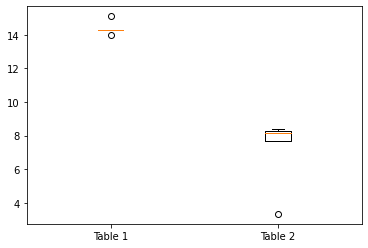

In [16]:
import matplotlib.pyplot as plt
#Plot the boxplot

fig, ax = plt.subplots() 
bp1 = ax.boxplot([iperf_s1_df["Throughput"],iperf_s2_df["Throughput"]], labels=["Table 1","Table 2"]) 
# bp2 = ax.boxplot(iperf_s2_df["Throughput"], labels=["Table 2"])
plt.show()

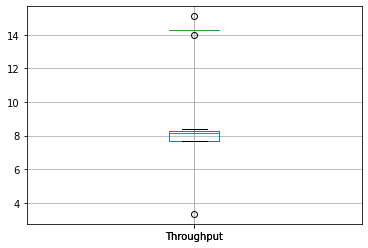

In [17]:
fig, ax = plt.subplots() 
iperf_s1_df.boxplot(column="Throughput", ax=ax, labels=["Table 1"]) 
iperf_s2_df.boxplot(column="Throughput", ax=ax, labels=["Table 2"])
plt.show()

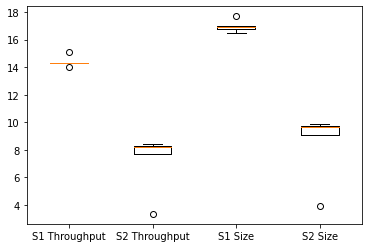

In [18]:
import matplotlib.pyplot as plt
#Plot the boxplot

fig, ax = plt.subplots() 
bp1 = ax.boxplot([iperf_s1_df["Throughput"],iperf_s2_df["Throughput"],iperf_s1_df["Size"],iperf_s2_df["Size"]], labels=["S1 Throughput","S2 Throughput","S1 Size","S2 Size"]) 
# bp2 = ax.boxplot(iperf_s2_df["Throughput"], labels=["Table 2"])
plt.show()

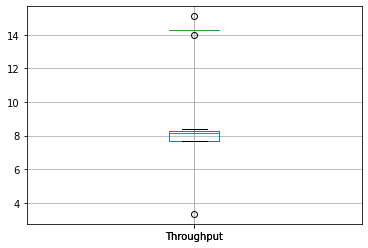

In [19]:
fig, ax = plt.subplots() 
iperf_s1_df.boxplot(column="Throughput", ax=ax, labels=["Table 1"]) 
iperf_s2_df.boxplot(column="Throughput", ax=ax, labels=["Table 2"])
plt.show()